# Logistic Regression (manual SGD) — Avazu CTR subset
**Goal:** Predict binary `click` from a small feature subset using from-scratch SGD (no `torch.optim` / `nn.Module`).


In [1]:
from google.colab import drive
drive.mount('/content/drive')

# UPDATE this if you saved the file elsewhere in Drive:
PATH = "/content/drive/MyDrive/avazu/train.gz"

# (Optional) sanity check
!ls -lh "$PATH"

Mounted at /content/drive
-rw------- 1 root root 1.1G Sep 28 18:42 /content/drive/MyDrive/avazu/train.gz


## Data & Preprocessing (summary)
- Load `train.gz` subset (N_ROWS=___) and select a few columns.
- Parse `hour → hour_of_day`.
- One-hot top-K categories; standardize numeric (fit on train only); add bias column.
- 80/20 train/val split.


In [2]:
import pandas as pd

# Keep runtime/RAM reasonable. You can bump to 300_000+ if the session has RAM.
N_ROWS = 200_000

# A small, sensible feature set for CTR:
USE_COLS = [
    "click", "hour", "C1", "banner_pos",
    "site_category", "device_type", "device_conn_type",
    "C14", "C17", "C20", "C21",
]

df = pd.read_csv(PATH, compression="gzip", usecols=USE_COLS, nrows=N_ROWS)

# Target as 0/1 ints
df["click"] = df["click"].astype("int32")

# hour column is yyyymmddHH → extract hour_of_day = HH
df["hour_str"]    = df["hour"].astype(str).str.zfill(10)
df["hour_of_day"] = df["hour_str"].str[-2:].astype(int)
df.drop(columns=["hour", "hour_str"], inplace=True)

print(df.shape)
df.head()


(200000, 11)


,click,C1,banner_pos,site_category,device_type,device_conn_type,C14,C17,C20,C21,hour_of_day
0,0,1005,0,28905ebd,1,2,15706,1722,-1,79,0
1,0,1005,0,28905ebd,1,0,15704,1722,100084,79,0
2,0,1005,0,28905ebd,1,0,15704,1722,100084,79,0
3,0,1005,0,28905ebd,1,0,15706,1722,100084,79,0
4,0,1005,1,0569f928,1,0,18993,2161,-1,157,0


## Model & Training (what we optimize)
- Model: ŷ = σ(Xw)  (logistic since `click` ∈ {0,1}).
- Loss: Binary Cross-Entropy + L2.
- SGD (manual): r = ŷ − y;  ∇w = (Xᵀ r)/B + 2λw;  update: w ← w − η∇w.


In [3]:
import numpy as np
import pandas as pd
import torch

torch.manual_seed(42)

CAT_COLS = ["C1","banner_pos","site_category","device_type","device_conn_type"]
NUM_COLS = ["C14","C17","C20","C21","hour_of_day"]
TARGET_COL = "click"
TOPK = 10  # keep top-10 categories per categorical column

df_prep = df.copy()

# Ensure categoricals are strings; bucket rare levels into "__OTHER__"
for c in CAT_COLS:
    df_prep[c] = df_prep[c].astype(str)
    top = df_prep[c].value_counts().nlargest(TOPK).index
    df_prep[c] = np.where(df_prep[c].isin(top), df_prep[c], "__OTHER__")

# One-hot encode categoricals as float32 (avoid object/sparse dtypes)
X_cat = pd.get_dummies(df_prep[CAT_COLS], drop_first=True, dtype=np.float32)

# Numeric block as float32; coerce any weird entries to NaN then fill
X_num = df_prep[NUM_COLS].apply(pd.to_numeric, errors="coerce").astype(np.float32)

# Concatenate features and ensure all float32
X_df = pd.concat([X_num, X_cat], axis=1)
X_df = X_df.astype(np.float32)            # <- force numeric dtype
X_df = X_df.fillna(0.0)                   # <- in case coercion created NaNs

# Target
y_arr = df_prep[TARGET_COL].astype("float32").values

# Train/val split (80/20) with reproducible shuffle
rng = np.random.default_rng(42)
idx = np.arange(len(X_df))
rng.shuffle(idx)
n_val = int(0.2 * len(X_df))
val_idx, trn_idx = idx[:n_val], idx[n_val:]

X_train_df, X_val_df = X_df.iloc[trn_idx].copy(), X_df.iloc[val_idx].copy()
y_train_arr, y_val_arr = y_arr[trn_idx], y_arr[val_idx]

# Standardize numeric columns using TRAIN stats only
mu = X_train_df[NUM_COLS].mean()
sd = X_train_df[NUM_COLS].std().replace(0, 1.0)
X_train_df.loc[:, NUM_COLS] = (X_train_df.loc[:, NUM_COLS] - mu) / sd
X_val_df.loc[:,   NUM_COLS] = (X_val_df.loc[:,   NUM_COLS] - mu) / sd

# Add bias column (first col of ones) as float32
X_train_df.insert(0, "bias", np.float32(1.0))
X_val_df.insert(0,   "bias", np.float32(1.0))

# FINAL: convert to numpy float32 then to torch (avoids object dtype)
X_train = torch.from_numpy(X_train_df.to_numpy(dtype=np.float32, copy=True))
X_val   = torch.from_numpy(X_val_df.to_numpy(dtype=np.float32, copy=True))
y_train = torch.from_numpy(y_train_arr.astype(np.float32))
y_val   = torch.from_numpy(y_val_arr.astype(np.float32))

print("X_train:", X_train.shape, "X_val:", X_val.shape)
print("dtypes OK? ->", X_train.dtype, X_val.dtype, y_train.dtype, y_val.dtype)
print("Pos rate train/val:", float(y_train.mean()), float(y_val.mean()))


X_train: torch.Size([160000, 32]) X_val: torch.Size([40000, 32])
dtypes OK? -> torch.float32 torch.float32 torch.float32 torch.float32
Pos rate train/val: 0.17486250400543213 0.17432500422000885


In [4]:
import torch
import matplotlib.pyplot as plt

def sigmoid(z: torch.Tensor) -> torch.Tensor:
    return 1.0 / (1.0 + torch.exp(-z))

def bce_loss_from_probs(p: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    # Numerically stable BCE on probabilities
    eps = 1e-12
    p = torch.clamp(p, eps, 1 - eps)
    return -(y * torch.log(p) + (1 - y) * torch.log(1 - p)).mean()

def precision_recall_curve_scores(y_true: torch.Tensor, scores: torch.Tensor, num_thresh: int = 200):
    # Build thresholds from descending score quantiles
    qs = torch.linspace(0, 1, num_thresh)
    thresholds = torch.quantile(scores, 1 - qs)
    precisions, recalls = [], []
    y_true = y_true.float()
    for t in thresholds:
        preds = (scores >= t).float()
        TP = ((preds == 1) & (y_true == 1)).sum().item()
        FP = ((preds == 1) & (y_true == 0)).sum().item()
        FN = ((preds == 0) & (y_true == 1)).sum().item()
        precision = TP / (TP + FP) if (TP + FP) > 0 else 1.0
        recall    = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        precisions.append(precision)
        recalls.append(recall)
    return torch.tensor(precisions), torch.tensor(recalls), thresholds

def sgd_loop_logreg(
    X_train: torch.Tensor, y_train: torch.Tensor,
    X_val: torch.Tensor,   y_val: torch.Tensor,
    w: torch.Tensor,
    learning_rate: float,
    epochs: int,
    lambda_reg: float,
    n_samples: int,
    batch_size: int = 256,
):
    # Ensure shapes
    if w.ndim == 2 and w.shape[1] == 1:
        w = w.squeeze(1)
    y_train = y_train.float()
    y_val   = y_val.float()
    w = w.clone().detach()

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Mini-batch passes
        for _ in range(0, n_samples, batch_size):
            idx = torch.randperm(n_samples)[:batch_size]
            xb = X_train[idx]                 # (B, d)
            yb = y_train[idx]                 # (B,)

            # Forward
            logits = xb @ w                   # (B,)
            p = sigmoid(logits)

            # Manual gradients
            r = (p - yb)                      # residual (B,)
            grad_w = (xb.t() @ r) / batch_size + 2.0 * lambda_reg * w

            # SGD update
            w -= learning_rate * grad_w

        # Epoch metrics
        with torch.no_grad():
            p_tr = sigmoid(X_train @ w)
            p_va = sigmoid(X_val   @ w)

            loss_tr = (bce_loss_from_probs(p_tr, y_train) + lambda_reg * (w*w).sum()).item()
            loss_va = (bce_loss_from_probs(p_va, y_val)   + lambda_reg * (w*w).sum()).item()
            train_losses.append(loss_tr)
            val_losses.append(loss_va)

            acc_tr = ((p_tr >= 0.5).float() == y_train).float().mean().item()
            acc_va = ((p_va >= 0.5).float() == y_val).float().mean().item()

        print(f"Epoch {epoch+1:02d} | train loss {loss_tr:.4f} acc {acc_tr:.3f} | val loss {loss_va:.4f} acc {acc_va:.3f}")

    # Plots: loss + PR curve (validation)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("BCE + L2"); plt.title("Training/Validation Loss")
    plt.legend()

    with torch.no_grad():
        scores = sigmoid(X_val @ w)
    prec, rec, _ = precision_recall_curve_scores(y_val, scores, num_thresh=200)
    plt.subplot(1,2,2)
    plt.plot(rec, prec, marker='.')
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall")
    plt.tight_layout(); plt.show()

    return w, train_losses, val_losses


Epoch 01 | train loss 0.4456 acc 0.825 | val loss 0.4451 acc 0.826
Epoch 02 | train loss 0.4449 acc 0.825 | val loss 0.4443 acc 0.826
Epoch 03 | train loss 0.4448 acc 0.825 | val loss 0.4441 acc 0.826
Epoch 04 | train loss 0.4448 acc 0.825 | val loss 0.4441 acc 0.826
Epoch 05 | train loss 0.4448 acc 0.825 | val loss 0.4442 acc 0.826
Epoch 06 | train loss 0.4447 acc 0.825 | val loss 0.4440 acc 0.826
Epoch 07 | train loss 0.4447 acc 0.825 | val loss 0.4440 acc 0.826
Epoch 08 | train loss 0.4446 acc 0.825 | val loss 0.4439 acc 0.826
Epoch 09 | train loss 0.4448 acc 0.825 | val loss 0.4442 acc 0.826
Epoch 10 | train loss 0.4447 acc 0.825 | val loss 0.4439 acc 0.826
Epoch 11 | train loss 0.4449 acc 0.825 | val loss 0.4441 acc 0.826
Epoch 12 | train loss 0.4447 acc 0.825 | val loss 0.4440 acc 0.826
Epoch 13 | train loss 0.4448 acc 0.825 | val loss 0.4441 acc 0.826
Epoch 14 | train loss 0.4447 acc 0.825 | val loss 0.4439 acc 0.826
Epoch 15 | train loss 0.4447 acc 0.825 | val loss 0.4440 acc 0

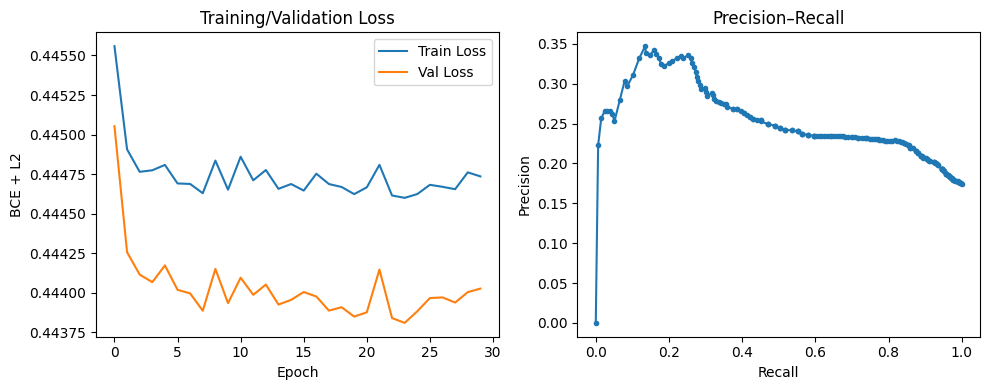

In [5]:
# Hyperparameters (tweak if needed)
LR         = 0.1
EPOCHS     = 30
LAMBDA_REG = 1e-3
BATCH_SIZE = 256

d  = X_train.shape[1]
w0 = torch.zeros(d)

w, tr_losses, va_losses = sgd_loop_logreg(
    X_train, y_train, X_val, y_val,
    w=w0,
    learning_rate=LR,
    epochs=EPOCHS,
    lambda_reg=LAMBDA_REG,
    n_samples=len(X_train),
    batch_size=BATCH_SIZE,
)


## Results (quick notes)
- Best val loss: ___ at epoch ___; val acc@0.5: ___; pos rate train/val: ___ / ___.
- PR curve: higher threshold → ↑precision, ↓recall; lower threshold → ↑recall, ↓precision.
